 # HAR ( Human Activity Recognition : 人間行動認識 )

　人間行動認識とは，カメラやセンサなどの様々な機器から得られた情報をもとに，人間の行動を学習･推定する認識技術分野のことである．今回は，スマホのIMU情報(姿勢･重力･角速度･ユーザの加速度)をもとに，ユーザの行動を下記の行動1～6の中から予測する．

1.	階段を降りている
1.	階段を登っている
1.	歩いている
1.	ジョギングしている
1.	座っている
1.	立っている  



## 1) データセットの準備


---

　まず，https://www.kaggle.com/malekzadeh/motionsense-dataset/ からダウンロードできるデータセットのzipファイルをこのipynbファイルと同じディレクトリに保存して下さい．



In [1]:
# zipを解凍
!unzip motionsense-dataset.zip

Archive:  motionsense-dataset.zip
  inflating: A_DeviceMotion_data/A_DeviceMotion_data/dws_1/sub_1.csv  
  inflating: A_DeviceMotion_data/A_DeviceMotion_data/dws_1/sub_10.csv  
  inflating: A_DeviceMotion_data/A_DeviceMotion_data/dws_1/sub_11.csv  
  inflating: A_DeviceMotion_data/A_DeviceMotion_data/dws_1/sub_12.csv  
  inflating: A_DeviceMotion_data/A_DeviceMotion_data/dws_1/sub_13.csv  
  inflating: A_DeviceMotion_data/A_DeviceMotion_data/dws_1/sub_14.csv  
  inflating: A_DeviceMotion_data/A_DeviceMotion_data/dws_1/sub_15.csv  
  inflating: A_DeviceMotion_data/A_DeviceMotion_data/dws_1/sub_16.csv  
  inflating: A_DeviceMotion_data/A_DeviceMotion_data/dws_1/sub_17.csv  
  inflating: A_DeviceMotion_data/A_DeviceMotion_data/dws_1/sub_18.csv  
  inflating: A_DeviceMotion_data/A_DeviceMotion_data/dws_1/sub_19.csv  
  inflating: A_DeviceMotion_data/A_DeviceMotion_data/dws_1/sub_2.csv  
  inflating: A_DeviceMotion_data/A_DeviceMotion_data/dws_1/sub_20.csv  
  inflating: A_DeviceMotion_data

　解凍したデータセットには，24人の被験者の情報および，被験者が上記の6つの行動をとっている時のIMU情報(姿勢･重力･角速度･ユーザの加速度)が含まれている．

　ただし，各被験者が行動1～3は3回ずつ，行動4～6は2回ずつ測定を行っているため，合計24人×(3回×3 + 2回×3) = 360個のCSVファイルが含まれる．また，IMUのサンプリング周波数は50Hzであった．  
　360個のCSVファイルからトレーニングデータとテストデータを作成する．今回は，行動1～6それぞれ1回の試行をテストデータとし，残りをトレーニングデータとする．つまり，24人×6回 = 144個のCSVをテストデータに，24人×9回 = 216個のCSVをトレーニングデータとして扱う．

In [2]:
# 360個のCSVファイルからトレーニングデータとテストデータを作成
import numpy as np
import pandas as pd

# ==== data_subjects_info.csvに記載されている24人の被験者の情報を取り出す ===========================
def get_ds_infos():
  dss = np.genfromtxt("data_subjects_info.csv",delimiter=',')
  dss = dss[1:]   # 1行目を除く
  return dss      # 0:被験者ID, 1:体重, 2:身長, 3:年齢, 4:性別

# ==== 各被験者ごとに分かれているcsvファイルを1つにまとめ，時系列データを作成 ========================
def create_time_series_data(num_features, num_act_labels, num_gen_labels, act_labels, trial_id):
  ds_list = get_ds_infos()                                              # 被験者情報を取得
  dataset_columns = num_features + num_gen_labels + num_act_labels      # データセットの列数 = センサデータ数 + 性別ラベル数 + 行動ラベル数
  
  # 訓練データとテストデータを初期化(これを最後に返す)
  train_data = np.zeros((0, dataset_columns))
  test_data = np.zeros((0, dataset_columns))
  
  for i, sub_id in enumerate(ds_list[:, 0]):      # 被験者IDでループ
    for j, act in enumerate(act_labels):          # 行動ラベルでループ
      for trial in trial_id[act]:                 # 試行回数でループ
        fname = 'A_DeviceMotion_data/'+'A_DeviceMotion_data/'+act+'_'+str(trial)+'/sub_'+str(int(sub_id))+'.csv'
        raw_data = pd.read_csv(fname)                                     # csvから生データを取得
        raw_data = raw_data.drop(['Unnamed: 0'], axis=1)                  # ゴミデータ(1列目)を除く
        unlabel_data = raw_data.values  
        label_data = np.zeros((len(unlabel_data), dataset_columns))
        label_data[:,:-(num_act_labels + num_gen_labels)] = unlabel_data
        label_data[:,-1] = act_labels[act]
        label_data[:,-2] = int(ds_list[i,4])

        if trial < 11:          # 10回目以下の試行はトレーニングデータ
          train_data = np.append(train_data, label_data, axis = 0)
        else:                   # 11回目以上の試行はテストデータ
          test_data = np.append(test_data, label_data, axis = 0)

  return train_data , test_data

# ==== 訓練データとテストデータの作成 ===================================================================
num_features = 12       #    IMU情報   : 姿勢(ロール, ピッチ, ヨー), 重力(x, y, z), 角速度(x, y, z), ユーザ加速度(x,y,z)
num_act_labels = 1      # 行動ラベル数 : dws, ups, wlk, jog, sit, std
num_gen_labels = 1      #     性別     : 0/1(female/male)

act_labels = {"dws":1, "ups":2, "wlk":3, "jog":4, "sit":5, "std":6}
trial_id = {"dws":[1,2,11], "ups":[3,4,12], "wlk":[7,8,15], "jog":[9,16], "sit":[5,13], "std":[6,14]}    

# データ作成
train_ts, test_ts = create_time_series_data(num_features, num_act_labels, num_gen_labels, act_labels, trial_id)

print("トレーニングデータ形状:", train_ts.shape)
print("テストデータ形状:", test_ts.shape)

トレーニングデータ形状: (1081446, 14)
テストデータ形状: (331419, 14)


In [3]:
# CSVの保存
header = "attitude.roll,attitude.pitch,attitude.yaw,gravity.x,gravity.y,gravity.z,rotationRate.x,rotationRate.y,rotationRate.z,userAcceleration.x,userAcceleration.y,userAcceleration.z,Gender,CorrectAnserLabel"
fmt = "%.6f, %.6f, %.6f, %.6f, %.6f, %.6f, %.6f, %.6f, %.6f, %.6f, %.6f, %.6f, %d, %d"
np.savetxt('train_raw.csv', train_ts, fmt=fmt, delimiter=',', header=header, comments="")
np.savetxt('test_raw.csv', test_ts, fmt=fmt, delimiter=',', header=header, comments="")
print("CSV saved successfully")

CSV saved successfully


　ひとまずCSVの保存まで完了したが，今回は重い計算したくないので，データの削減を行う．

In [4]:
# データセットが150MB程度あるので，5行に1行だけ使うことでデータを削減
import pandas as pd

# CSVファイルの読み込み
def load_data():
  return pd.read_csv("train_raw.csv"), pd.read_csv("test_raw.csv")

train_data_raw, test_data_raw = load_data()

# 5行に1行取り出し
train_data_reduction = train_data_raw.query('index % 5 == 0')
test_data_reduction = test_data_raw.query('index % 5 == 0')

# CSVの保存
train_data_reduction.to_csv("train.csv")
test_data_reduction.to_csv("test.csv")
print("CSV saved successfully")

CSV saved successfully


## 2) データの読み込みと加工


---



In [5]:
# まずは，CSVを読み込んで中身を確認
import numpy as np
import pandas as pd

# CSVファイルの読み込み
def load_data():
  return pd.read_csv("train.csv"), pd.read_csv("test.csv")

train_data, test_data = load_data()

# ゴミデータ(1列目)を削除
train_data = train_data.drop(['Unnamed: 0'], axis=1)
test_data = test_data.drop(['Unnamed: 0'], axis=1)

print("========= トレーニングデータ =============================================")
print(train_data,"\n")
print("============= テストデータ ===============================================")
print(test_data)

========= トレーニングデータ =============================================
        attitude.roll  attitude.pitch  ...  Gender  CorrectAnserLabel
0            1.528132       -0.733896  ...       1                  1
1            1.476302       -0.700807  ...       1                  1
2            1.434186       -0.693527  ...       1                  1
3            1.137867       -0.639672  ...       1                  1
4            0.916433       -0.655642  ...       1                  1
...               ...             ...  ...     ...                ...
216285      -0.245861       -1.449192  ...       0                  6
216286      -0.144484       -1.447449  ...       0                  6
216287      -0.054519       -1.450084  ...       0                  6
216288       0.014894       -1.445758  ...       0                  6
216289       0.068046       -1.445550  ...       0                  6

[216290 rows x 14 columns] 

============= テストデータ ===========================================

In [6]:
# データの欠損がないか確認
pd.set_option('display.max_columns', 14)
print(train_data.describe())
pd.reset_option('display.max_columns')

       attitude.roll  attitude.pitch   attitude.yaw      gravity.x  \
count  216290.000000   216290.000000  216290.000000  216290.000000   
mean       -0.180388       -1.027508      -0.126891       0.037576   
std         1.588032        0.450585       1.541152       0.332303   
min        -3.141551       -1.567685      -3.141588      -0.999612   
25%        -1.537733       -1.364888      -1.242785      -0.169055   
50%         0.101366       -1.193118      -0.138958       0.018564   
75%         0.901633       -0.781504       0.847209       0.250680   
max         3.141565        1.567175       3.141574       0.999901   

           gravity.y      gravity.z  rotationRate.x  rotationRate.y  \
count  216290.000000  216290.000000   216290.000000   216290.000000   
mean        0.784542      -0.124646        0.004909        0.014150   
std         0.297075       0.410916        1.320371        1.245072   
min        -0.999993      -0.999999      -16.020784      -17.232466   
25%         0.

In [0]:
# 各種定数の定義
num_features = 12       #    IMU情報   : 姿勢(ロール, ピッチ, ヨー), 重力(x, y, z), 角速度(x, y, z), ユーザ加速度(x,y,z)
num_act_labels = 1      # 行動ラベル数 : dws, ups, wlk, jog, sit, std
num_gen_labels = 1      #     性別     : 0/1(female/male)

act_labels = {"dws":1, "ups":2, "wlk":3, "jog":4, "sit":5, "std":6}

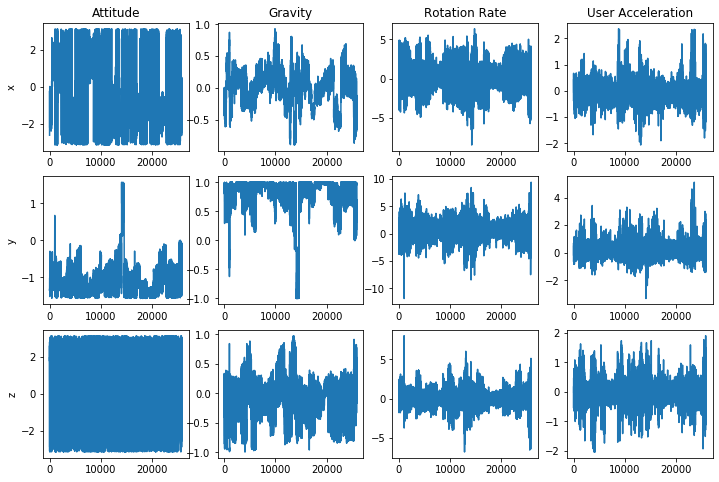

In [8]:
# データの中身を描画
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (12.0, 8.0)

def get_column(act, type):
  data = train_data[train_data["CorrectAnserLabel"]==act_labels[act]][type].values
  length = len(train_data[train_data["CorrectAnserLabel"]==act_labels[act]][type].values)
  return length, data

act = "ups"    # {"dws", "ups", "wlk", "jog", "sit", "std"} から選択
num_rows = 3
num_columns = 4
types = ["attitude.roll","gravity.x","rotationRate.x","userAcceleration.x","attitude.pitch","gravity.y","rotationRate.y","userAcceleration.y","attitude.yaw","gravity.z","rotationRate.z","userAcceleration.z"]

for i, type in enumerate(types):
  data = get_column("ups", type)
  plt.subplot(num_rows, num_columns, i+1)
  plt.plot(range(data[0]), data[1])
  
  if i+1==1:
    plt.title("Attitude")
    plt.ylabel("x")
  elif i+1==2:
    plt.title("Gravity")
  elif i+1==3:
    plt.title("Rotation Rate")
  elif i+1==4:
    plt.title("User Acceleration")
  elif i+1==5:
    plt.ylabel("y")
  elif i+1==9:
    plt.ylabel("z")


　上のコードセルで描画したグラフは，被験者が階段を登っている時のスマホIMU情報である．センサの値を目で確認しても，ノイズが大きく，被験者がどんな行動を取っているのかよく分からないが，以下ではこのセンサの値から行動ラベルを予測していく．

In [0]:
# NumPy配列に変換
train_data = train_data.values
test_data = test_data.values

　まず，CSVから取得したトレーニングデータとテストデータを，学習に用いる形状に加工する．IMU情報は時系列データであり，ある時刻でのデータとラベルだけでは意味を持たない．そこで，一定時間分のデータを1つのセクションとして扱い，セクションの集合を学習に用いるトレーニングデータとする．  
　セクションに分割する際に必要となるパラメータはセクションのサイズと，スライドサイズである．セクションサイズは1セクションに何サンプル含めるかを決めるパラメータで，サンプリング周波数が50Hzであることから，セクションサイズが50の場合は1セクションに1分間のデータが含まれる．(ただし，今回はデータを1/5に削減しているので，1セクション12秒間に相当する．) また，スライドサイズは1つ後のセクションをどれだけずらして開始するかを決めるパラメータであり，小さすぎると計算コストが高くなる可能性がある．   
　セクションサイズを50，スライドサイズを10として，セクションに分割するコードを以下に示す．

In [0]:
# 時系列データをセクションに分割する関数
def time_series_to_section(dataset, num_act_labels, num_gen_labels, size_sections, size_slide, standardize = False, **options):
  data = dataset[: , 0:-num_act_labels]           # IMUデータ+性別ラベルを取得
  act_labels = dataset[: , -(num_act_labels)]     # 行動ラベルを取得
 
  # === 標準化 =============================
  if standardize:
    if options:             # 引数で平均･分散を指定した場合
      mean = options.get("mean")
      std = options.get("std")
      print("トレーニングデータの平均と分散を用いてテストデータを標準化しました．")
    else:                   # 指定のない場合は標準化
      mean = data.mean(axis=0)
      std = data.std(axis=0)
      print("平均:",str(mean.mean()),", 分散:",str(std.mean()), "---> 標準化しました．")           
    data = (data - mean) / std
  else:
    print("標準化していません．")

  # あとで3次元配列に格納するために，一旦転置しておく
  data = data.T
          
  size_features = data.shape[0]
  size_data = data.shape[1]
  num_sections = 1 + ( (size_data - size_sections) // size_slide ) 
          
  # 1セクションのデータ形状を定義
  data_sections = np.zeros((num_sections, size_features, size_sections))
  act_secs_labels = np.zeros(num_sections)
   
  for count_section in range(num_sections):   # 各セクションの第1要素のindex
    section_first_index = count_section * size_slide     # セクションカウント
    if(count_section >= num_sections):    # セクション数を超えたら終了     
      break
    if act_labels[section_first_index] != act_labels[section_first_index+size_sections-1]:    # セクション内で行動ラベルが全て一緒でない時は無視
      continue    
    data_sections[count_section] = data[0:size_features, section_first_index:section_first_index+size_sections]   # セクションデータのcount_section要素目に代入
    act_secs_labels[count_section] = act_labels[section_first_index].astype(int)
  
  return data_sections, act_secs_labels, mean, std

In [11]:
size_sections = 50   # セクションサイズ
size_slide = 10      # スライドサイズ

# 時系列データをセクション分割
print("分割後のセクション形状: (",num_features+num_gen_labels,"x",size_sections,")")
X_train, y_train, train_mean, train_std = time_series_to_section( train_data.copy(),
                                                                  num_act_labels,
                                                                  num_gen_labels,
                                                                  size_sections,
                                                                  size_slide,
                                                                  standardize = True )

X_test, y_test, test_mean, test_std = time_series_to_section( test_data.copy(),
                                                              num_act_labels,
                                                              num_gen_labels,
                                                              size_sections,
                                                              size_slide,
                                                              standardize = True,
                                                              mean = train_mean, 
                                                              std = train_std  )
print("トレーニングデータ形状:", X_train.shape)
print("テストデータ形状:", X_test.shape)

分割後のセクション形状: ( 13 x 50 )
平均: 0.0035300797597241063 , 分散: 0.749962379300086 ---> 標準化しました．
トレーニングデータの平均と分散を用いてテストデータを標準化しました．
トレーニングデータ形状: (21625, 13, 50)
テストデータ形状: (6624, 13, 50)


## 3) 次元圧縮と行動の予測


---

　では，実際にIMU情報を用いた人間行動認識を行う．
以下では，

*   PCAによる次元圧縮
*   決定木による予測
*   ブースティング(Adaboost)による予測
*   ランダムフォレストによる予測
*   交差検証法によるランダムフォレストのハイパーパラメータ探索

を行っている．



### 3-1) PCAによる次元圧縮

In [0]:
# PCAによる次元圧縮
from sklearn.decomposition import PCA

# 2次元データを1次元データに変換
X_train_flatten = X_train.reshape(X_train.shape[0], X_train.shape[1]*X_train.shape[2]) 
X_test_flatten  = X_test.reshape(X_test.shape[0], X_test.shape[1]*X_test.shape[2]) 

pca = PCA(n_components=2, random_state=0)   # 2次元に圧縮
pca.fit(X_train_flatten)                    # 主成分の取得
Xpca_train = pca.transform(X_train_flatten) # PCAによる次元圧縮
Xpca_test = pca.transform(X_test_flatten)

### 3-2) 決定木による予測

In [13]:
# 決定木による予測
from sklearn.tree import DecisionTreeClassifier

model_simple = DecisionTreeClassifier(max_depth=5, random_state=0)
model_simple.fit(Xpca_train, y_train)

pred_y_test = model_simple.predict(Xpca_test)
prediction_result = (pred_y_test == y_test)
accuracy = np.mean(prediction_result)
print("テストデータの予測正解率 : ", accuracy)

テストデータの予測正解率 :  0.6296799516908212


### 3-3) ブースティング(Adaboost)による予測

In [14]:
# Adaboostによる予測  (注意 : 40秒程度かかります)
from sklearn import tree, metrics, ensemble
import time
start = time.time() # 計算開始時刻

single_tree = tree.DecisionTreeClassifier(max_depth=6, random_state=0) 
adaDT = ensemble.AdaBoostClassifier(base_estimator=single_tree, n_estimators=1000, random_state=0)
adaDT.fit(Xpca_train, y_train)
pred_y_test = adaDT.predict(Xpca_test)

print("テストデータの予測正解率 : ", metrics.accuracy_score(pred_y_test, y_test)) # test accuracy

end = time.time() # 計算終了時刻
print("計算時間 : ", end - start) # 差を秒単位で計算

テストデータの予測正解率 :  0.5157004830917874
計算時間 :  43.043667793273926


### 3-4) ランダムフォレストによる予測

In [15]:
# ランダムフォレストによる予測
from sklearn import tree, metrics, ensemble

RF = ensemble.RandomForestClassifier(max_depth=7, min_samples_leaf=4 ,n_estimators=1000, random_state=0, n_jobs=-1)
RF.fit(Xpca_train, y_train) 
pred_y_test = RF.predict(Xpca_test)

print("テストデータの予測正解率 : ", metrics.accuracy_score(pred_y_test, y_test)) # test accuracy

テストデータの予測正解率 :  0.6666666666666666


### 3-5) 交差検証法によるランダムフォレストのハイパーパラメータ探索

　上記の例では，`max_depth`を7，`min_samples_leaf`を4としてランダムフォレストを適用し，**66.67%**で予測できている．では，クロスバリデーションを用いてランダムフォレストのハイパーパラメータ探索を行い，予測正解率の向上を図る．  
【注意】以下のコードの実行は3～4分かかります．

In [16]:
# クロスバリデーションからmax_depthとmin_samples_leafの最適な値を求める
from sklearn.model_selection import GridSearchCV

np.random.seed(0)

# 辞書型が1つ入った配列
param_grid = [  
  { 
    "max_depth": [4,5,6,7],
    "min_samples_leaf": [2,3,4]
  } 
] 
grid_search_dt = GridSearchCV(RF, param_grid, cv=4, verbose=2)   # 4-fold CVをしながら最適なモデルを決定する
grid_search_dt.fit(Xpca_train, y_train)
print("\n", "最適ハイパーパラメータ : ", grid_search_dt.best_params_)
# print(grid_search_dt.best_score_)


Fitting 4 folds for each of 12 candidates, totalling 48 fits
[CV] max_depth=4, min_samples_leaf=2 .................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .................. max_depth=4, min_samples_leaf=2, total=   4.6s
[CV] max_depth=4, min_samples_leaf=2 .................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.6s remaining:    0.0s


[CV] .................. max_depth=4, min_samples_leaf=2, total=   3.8s
[CV] max_depth=4, min_samples_leaf=2 .................................
[CV] .................. max_depth=4, min_samples_leaf=2, total=   3.8s
[CV] max_depth=4, min_samples_leaf=2 .................................
[CV] .................. max_depth=4, min_samples_leaf=2, total=   3.8s
[CV] max_depth=4, min_samples_leaf=3 .................................
[CV] .................. max_depth=4, min_samples_leaf=3, total=   3.8s
[CV] max_depth=4, min_samples_leaf=3 .................................
[CV] .................. max_depth=4, min_samples_leaf=3, total=   3.7s
[CV] max_depth=4, min_samples_leaf=3 .................................
[CV] .................. max_depth=4, min_samples_leaf=3, total=   3.8s
[CV] max_depth=4, min_samples_leaf=3 .................................
[CV] .................. max_depth=4, min_samples_leaf=3, total=   3.9s
[CV] max_depth=4, min_samples_leaf=4 .................................
[CV] .

[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed:  3.6min finished



 最適ハイパーパラメータ :  {'max_depth': 5, 'min_samples_leaf': 3}


　クロスバリデーションによるハイパーパラメータ探索から，`max_depth`を5，`min_samples_leaf`を3としてランダムフォレストを適用すると，先程よりも汎化性能が上がり，テストデータの予測正解率が**66.67 %**→**67.42 %**と少し向上していることが確認できる．

In [17]:
RF = ensemble.RandomForestClassifier(max_depth=5, min_samples_leaf=3, n_estimators=1000, random_state=0, n_jobs=-1)
RF.fit(Xpca_train, y_train)            # フィッティング
pred_y_test = RF.predict(Xpca_test)    # 予測
print("テストデータの予測正解率 : ", metrics.accuracy_score(pred_y_test, y_test)) # test accuracy

テストデータの予測正解率 :  0.6742149758454107


## 4) 考察


---


　以上より，ランダムフォレストを用いることで，人間の行動が**67.42%**で予測できることが分かった．  
　では，予測に失敗したデータについて考察する．まず，正解したサンプル数と不正解したサンプル数を，行動ラベルごとに分けて描画することにより，どの行動の認識が難しいのかを確認する．

各ラベルの正解数 [1, 4, 1004, 0, 1872, 884]
各ラベルの不正解数 [334, 435, 187, 477, 92, 633]


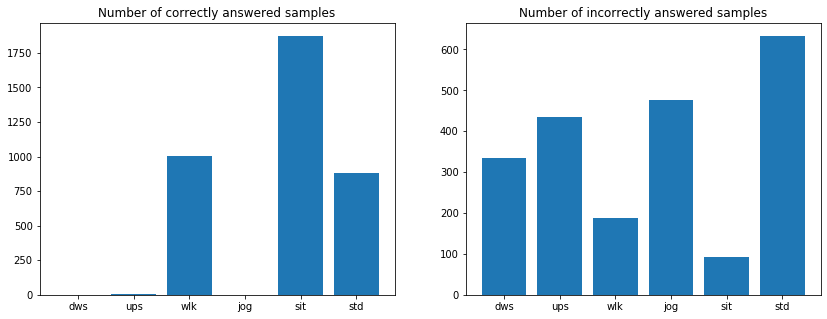

In [18]:
# 各ラベルについて正解/不正解のサンプル数を描画
result_bool = (pred_y_test == y_test)   # 予測が正解なら1, 間違いなら0

true_result = result_bool * y_test
false_result = np.logical_not(result_bool) * y_test

def count_label(list, label):
  return np.count_nonzero(list==label)

plt.rcParams['figure.figsize'] = (14.0, 5.0)
left = np.array([1, 2, 3, 4, 5, 6])
tick_label = ["dws", "ups", "wlk", "jog", "sit", "std"]

# 各ラベルにおける正解したサンプル数の描画
counts = [count_label(true_result, i) for i in range(1,7)]
print("各ラベルの正解数", counts)     # {"dws":1, "ups":2, "wlk":3, "jog":4, "sit":5, "std":6}
plt.subplot(1, 2, 1)
plt.bar(left, counts, tick_label=tick_label, align="center")
plt.title("Number of correctly answered samples")

# 各ラベルにおける不正解したサンプル数の描画
counts = [count_label(false_result, i) for i in range(1,7)]
print("各ラベルの不正解数", counts)     # {"dws":1, "ups":2, "wlk":3, "jog":4, "sit":5, "std":6}
plt.subplot(1, 2, 2)
plt.bar(left, counts, tick_label=tick_label, align="center")
plt.title("Number of incorrectly answered samples")

plt.show()


　上のグラフより，歩いている時および座っている時に比べ，他の動作の予測精度が悪いことが見て取れる．しかし，それ以前に階段の上り下りおよびジョギング動作においてほとんど正解していないことが気になる．次に，不正解だった行動ラベルにおいて，どの動作と間違えて予測してしまったのか描画し，確認する．

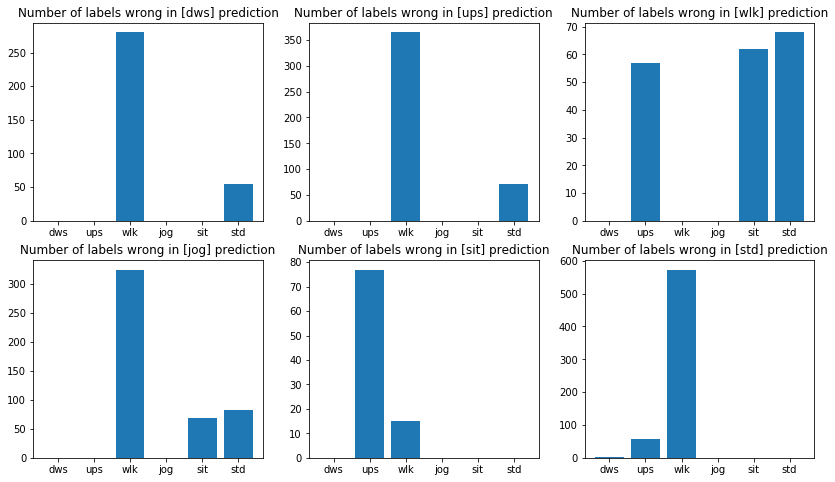

In [19]:
# 各正解ラベルを間違えた際に選択したラベルの数を描画
plt.rcParams['figure.figsize'] = (14.0, 8.0)
act_labels = {"dws":1, "ups":2, "wlk":3, "jog":4, "sit":5, "std":6}

for act_label in act_labels:
  false_label = (false_result==act_labels[act_label]) * pred_y_test
  counts = [count_label(false_label, i) for i in range(1,7)]
  plt.subplot(2, 3, act_labels[act_label])
  plt.title("Number of labels wrong in ["+str(act_label)+"] prediction")
  plt.bar(left, counts, tick_label=tick_label, align="center")

plt.show()

　明らかに歩行動作と誤予測したものが多い．これは，学習データに問題がある気がする．そこで，トレーニングデータのサンプル数をラベルごとに描画する．

トレーニングデータのラベル別サンプル数 [2069, 2466, 5463, 1969, 4574, 4378]


Text(0.5, 1.0, 'Number of training data samples by label')

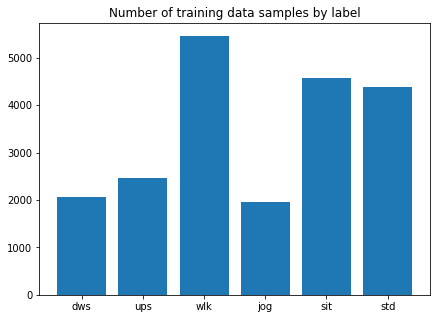

In [20]:
counts = [count_label(y_train, i) for i in range(1,7)]
print("トレーニングデータのラベル別サンプル数", counts)     # {"dws":1, "ups":2, "wlk":3, "jog":4, "sit":5, "std":6}
plt.rcParams['figure.figsize'] = (7.0, 5.0)
plt.bar(left, counts, tick_label=tick_label, align="center")
plt.title("Number of training data samples by label")

　たしかに，歩行動作のトレーニングデータのサンプル数が多くなっていることが確認できる．これは，単純に確認ミスであったので，各ラベルのサンプル数が等しくなるようにデータを用意し直す．

In [0]:
# 時系列データをセクションに分割する関数
def time_series_to_section(dataset, num_act_labels, num_gen_labels, size_sections, size_slide, standardize = False, **options):
  data = dataset[: , 0:-num_act_labels]           # IMUデータ+性別ラベルを取得
  act_labels_data = dataset[: , -(num_act_labels)]     # 行動ラベルを取得
 
  # === 標準化 =============================
  if standardize:
    if options:             # 引数で平均･分散を指定した場合
      mean = options.get("mean")
      std = options.get("std")
      print("トレーニングデータの平均と分散を用いてテストデータを標準化しました．")
    else:                   # 指定のない場合は標準化
      mean = data.mean(axis=0)
      std = data.std(axis=0)
      print("平均:",str(mean.mean()),", 分散:",str(std.mean()), "---> 標準化しました．")           
    data = (data - mean) / std
  else:
    print("標準化していません．")

  # あとで3次元配列に格納するために，一旦転置しておく
  data = data.T
          
  size_features = data.shape[0]
  size_data = data.shape[1]
  num_sections = 1 + ( (size_data - size_sections) // size_slide ) 
          
  # 1セクションのデータ形状を定義
  data_sections = np.zeros((num_sections, size_features, size_sections))
  act_secs_labels = np.zeros(num_sections)

  data_length = [0,0,0,0,0,0]
   
  for count_section in range(num_sections):   # 各セクションの第1要素のindex
    section_first_index = count_section * size_slide     # セクションカウント
    if(count_section >= num_sections):    # セクション数を超えたら終了     
      break
    if(data_length[int(act_labels_data[section_first_index])-1] > 3938):
      continue
    if act_labels_data[section_first_index] != act_labels_data[section_first_index+size_sections-1]:    # セクション内で行動ラベルが全て一緒でない時は無視
      continue    
    data_sections[count_section] = data[0:size_features, section_first_index:section_first_index+size_sections]   # セクションデータのcount_section要素目に代入
    act_secs_labels[count_section] = act_labels_data[section_first_index].astype(int)
    data_length[int(act_labels_data[section_first_index])-1] += 1
  
  return data_sections, act_secs_labels, mean, std

In [22]:
size_sections = 50   # セクションサイズ
size_slide = 5      # スライドサイズ

# 時系列データをセクション分割
print("分割後のセクション形状: (",num_features+num_gen_labels,"x",size_sections,")")
X_train, y_train, train_mean, train_std = time_series_to_section( train_data.copy(),
                                                                  num_act_labels,
                                                                  num_gen_labels,
                                                                  size_sections,
                                                                  size_slide,
                                                                  standardize = True )

X_test, y_test, test_mean, test_std = time_series_to_section( test_data.copy(),
                                                              num_act_labels,
                                                              num_gen_labels,
                                                              size_sections,
                                                              size_slide,
                                                              standardize = True,
                                                              mean = train_mean, 
                                                              std = train_std  )
print("トレーニングデータ形状:", X_train.shape)
print("テストデータ形状:", X_test.shape)

分割後のセクション形状: ( 13 x 50 )
平均: 0.0035300797597241063 , 分散: 0.749962379300086 ---> 標準化しました．
トレーニングデータの平均と分散を用いてテストデータを標準化しました．
トレーニングデータ形状: (43249, 13, 50)
テストデータ形状: (13247, 13, 50)


トレーニングデータのラベル別サンプル数 [3939, 3939, 3939, 3939, 3939, 3939]


Text(0.5, 1.0, 'Number of training data samples by label')

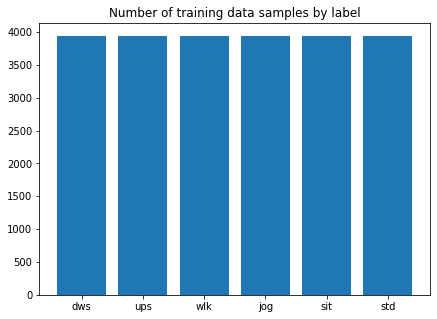

In [23]:
counts = [count_label(y_train, i) for i in range(1,7)]
print("トレーニングデータのラベル別サンプル数", counts)     # {"dws":1, "ups":2, "wlk":3, "jog":4, "sit":5, "std":6}
plt.rcParams['figure.figsize'] = (7.0, 5.0)
plt.bar(left, counts, tick_label=tick_label, align="center")
plt.title("Number of training data samples by label")

　これで，各ラベルについて同じサンプル数が確保されたトレーニングデータができた．では，PCAとランダムフォレストを用いて再度，次元圧縮および予測を行う．

In [0]:
# PCAによる次元圧縮
from sklearn.decomposition import PCA

# 2次元データを1次元データに変換
X_train_flatten = X_train.reshape(X_train.shape[0], X_train.shape[1]*X_train.shape[2]) 
X_test_flatten  = X_test.reshape(X_test.shape[0], X_test.shape[1]*X_test.shape[2]) 

pca = PCA(n_components=2, random_state=0)   # 2次元に圧縮
pca.fit(X_train_flatten)                    # 主成分の取得
Xpca_train = pca.transform(X_train_flatten) # PCAによる次元圧縮
Xpca_test = pca.transform(X_test_flatten)

In [25]:
RF = ensemble.RandomForestClassifier(max_depth=5, min_samples_leaf=3, n_estimators=1000, random_state=0, n_jobs=-1)
RF.fit(Xpca_train, y_train)            # フィッティング
pred_y_test = RF.predict(Xpca_test)    # 予測
print("テストデータの予測正解率 : ", metrics.accuracy_score(pred_y_test, y_test)) # test accuracy

テストデータの予測正解率 :  0.4794293047482449


各ラベルの正解数 [107, 120, 383, 463, 2617, 1254]
各ラベルの不正解数 [560, 760, 1994, 496, 1309, 1777]


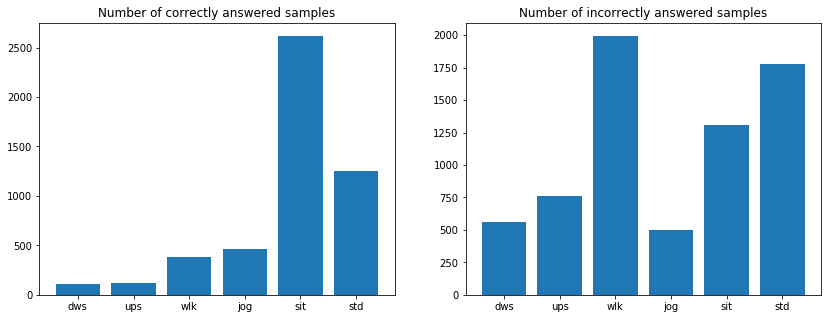

In [26]:
# 各ラベルについて正解/不正解のサンプル数を描画
result_bool = (pred_y_test == y_test)   # 予測が正解なら1, 間違いなら0

true_result = result_bool * y_test
false_result = np.logical_not(result_bool) * y_test

def count_label(list, label):
  return np.count_nonzero(list==label)

plt.rcParams['figure.figsize'] = (14.0, 5.0)
left = np.array([1, 2, 3, 4, 5, 6])
tick_label = ["dws", "ups", "wlk", "jog", "sit", "std"]

# 各ラベルにおける正解したサンプル数の描画
counts = [count_label(true_result, i) for i in range(1,7)]
print("各ラベルの正解数", counts)     # {"dws":1, "ups":2, "wlk":3, "jog":4, "sit":5, "std":6}
plt.subplot(1, 2, 1)
plt.bar(left, counts, tick_label=tick_label, align="center")
plt.title("Number of correctly answered samples")

# 各ラベルにおける不正解したサンプル数の描画
counts = [count_label(false_result, i) for i in range(1,7)]
print("各ラベルの不正解数", counts)     # {"dws":1, "ups":2, "wlk":3, "jog":4, "sit":5, "std":6}
plt.subplot(1, 2, 2)
plt.bar(left, counts, tick_label=tick_label, align="center")
plt.title("Number of incorrectly answered samples")

plt.show()


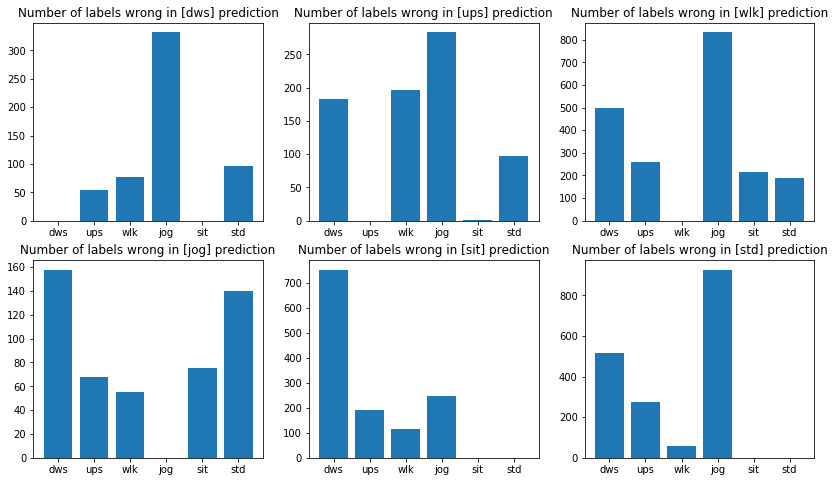

In [27]:
# 各正解ラベルを間違えた際に選択したラベルの数を描画
plt.rcParams['figure.figsize'] = (14.0, 8.0)
act_labels = {"dws":1, "ups":2, "wlk":3, "jog":4, "sit":5, "std":6}

for act_label in act_labels:
  false_label = (false_result==act_labels[act_label]) * pred_y_test
  counts = [count_label(false_label, i) for i in range(1,7)]
  plt.subplot(2, 3, act_labels[act_label])
  plt.title("Number of labels wrong in ["+str(act_label)+"] prediction")
  plt.bar(left, counts, tick_label=tick_label, align="center")

plt.show()

　むしろ予測正解率は下がってしまったが，不正解時に選択したラベルの偏りはなくなった．予測正解率の低下はデータの不足が原因と考えられる．データを1/5に削減した影響が大きかったように見える．